In [1]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras import metrics

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import datetime as dt



Using TensorFlow backend.


In [2]:
# Import whole N-MNIST Dataset
def load_NMNIST(path):
    """
    """
    xs_train = []
    ys_train = []
    xs_test = []
    ys_test = []

    for class_index in range(0, 10):
        for (root, dirs, dat_files) in os.walk('{0}/n_Train_3/{1}'.format(path, str(class_index))):
            for file in dat_files:
                single_X = np.fromfile('{0}/n_Train_3/{1}/{2}'.format(path, str(class_index), file), dtype=np.int32)
                xs_train.append(single_X)
                ys_train.append(class_index)

        for (root, dirs, dat_files) in os.walk('{0}/n_Test_3/{1}'.format(path, str(class_index))):
            for file in dat_files:
                xs_test.append(np.fromfile('{0}/n_Test_3/{1}/{2}'.format(path, str(class_index), file), dtype=np.int32))
                ys_test.append(class_index)

    Xtr = np.array(xs_train)
    Ytr = np.array(ys_train)
    Xte = np.array(xs_test)
    Yte = np.array(ys_test)

    return Xtr, Ytr, Xte, Yte

In [3]:
dataset_class_path = '/Users/ching/Desktop/Project/autoencoder_nmnist/NMNIST/datasets'
x_train_1, y_train, x_test_1, y_test = load_NMNIST(dataset_class_path)

In [4]:
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', x_train_1.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test_1.shape)
print('Test labels shape: ', y_test.shape)

# 34 x 34 x 2

Training data shape:  (60000, 2312)
Training labels shape:  (60000,)
Test data shape:  (10000, 2312)
Test labels shape:  (10000,)


In [5]:
maxi = x_train_1[0][0]
mini = x_train_1[0][0]
for i in range (0, len(x_train_1)):
    if (max(x_train_1[i])>maxi):
        maxi = max(x_train_1[i])
    if (min(x_train_1[i])<mini):
        mini = min(x_train_1[i])
print(maxi)
print(mini)

13
-15


In [43]:
# x_train = (x_train_1.astype('float32')+15) / 30
# x_test = (x_test_1.astype('float32')+15) / 30
x_train = (x_train_1.astype('float32'))/15
x_test = (x_test_1.astype('float32'))/15

In [44]:
'''for o in x_train:
    for i in range(0, len(o)):
        if (o[i]>0):
            o[i]=1
        if (o[i]<0):
            o[i]=-1'''
x_train[x_train>0]=1
x_train[x_train<0]=-1
x_test[x_test>0]=1
x_test[x_test<0]=-1
#print(x_train.shape)
print(max(x_train[0]))

1.0


In [7]:
epsilon_std=1

# z = z_mean + sqrt(var)*eps
#returns random value of z with the gives mean and variance
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma/2) * epsilon

In [72]:
# network parameters
#batch_size - number of training examples 
#that are used at the same time to train the NN
#latent_dim - defines the dimentionality of the latent space
#2D latent space in this case
input_shape = (2312, )
intermediate_dim_1 = 64
intermediate_dim_2 = 16
intermediate_dim_3 = 32
intermediate_dim_4 = 16
intermediate_dim_5 = 8
batch_size = 100
latent_dim = 2
epochs = 4

In [73]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim_1, activation='relu')(inputs)
#x = Dense(intermediate_dim_2, activation='relu')(x)
#x = Dense(intermediate_dim_3, activation='relu')(x)
#x = Dense(intermediate_dim_4, activation='relu')(x)
#x = Dense(intermediate_dim_5, activation='relu')(x)
# x = Dense(intermediate_dim_2, activation='relu')(inputs)
# x = Dense(intermediate_dim_3, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [74]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim_1, activation='tanh')(inputs)
x = Dense(intermediate_dim_2, activation='tanh')(x)
#x = Dense(intermediate_dim_3, activation='tanh')(x)
#x = Dense(intermediate_dim_4, activation='tanh')(x)
#x = Dense(intermediate_dim_5, activation='tanh')(x)
# x = Dense(intermediate_dim_2, activation='relu')(inputs)
# x = Dense(intermediate_dim_3, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [75]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 2312)         0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 64)           148032      encoder_input[0][0]              
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 16)           1040        dense_19[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            34          dense_20[0][0]                   
__________________________________________________________________________________________________
z_log_var 

In [76]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
#x = Dense(intermediate_dim_5, activation='tanh')(latent_inputs)
#x = Dense(intermediate_dim_4, activation='tanh')(latent_inputs)
#x = Dense(intermediate_dim_3, activation='tanh')(x)
x = Dense(intermediate_dim_2, activation='tanh')(latent_inputs)
x = Dense(intermediate_dim_1, activation='tanh')(x)
# x = Dense(intermediate_dim_3, activation='relu')(latent_inputs)
# x = Dense(intermediate_dim_2, activation='relu')(x)
outputs = Dense(2312, activation='tanh')(x)

In [392]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
#x = Dense(intermediate_dim_5, activation='relu')(latent_inputs)
#x = Dense(intermediate_dim_4, activation='relu')(x)
#x = Dense(intermediate_dim_3, activation='relu')(latent_inputs)
x = Dense(intermediate_dim_2, activation='relu')(latent_inputs)
x = Dense(intermediate_dim_1, activation='relu')(x)
# x = Dense(intermediate_dim_3, activation='relu')(latent_inputs)
# x = Dense(intermediate_dim_2, activation='relu')(x)
outputs = Dense(2312, activation='sigmoid')(x)

In [77]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_22 (Dense)             (None, 64)                1088      
_________________________________________________________________
dense_23 (Dense)             (None, 2312)              150280    
Total params: 151,416
Trainable params: 151,416
Non-trainable params: 0
_________________________________________________________________


In [78]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae_test=Model(inputs, outputs, name='vae_test')

In [79]:
# Compute VAE loss
xent_loss = 2312 * binary_crossentropy(inputs, outputs)
#xent_loss = binary_crossentropy(inputs, outputs)

kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss =abs(K.mean(xent_loss + kl_loss))

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae_test.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
vae.summary()
vae_test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 2312)              0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 149140    
_________________________________________________________________
decoder (Model)              (None, 2312)              151416    
Total params: 300,556
Trainable params: 300,556
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 2312)              0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 149140    
_________________________________________________________________
deco

In [80]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 12s 207us/step - loss: 30.1521 - val_loss: 85.1139
Epoch 2/4
60000/60000 [==============================] - 10s 168us/step - loss: 24.1253 - val_loss: 68.9879
Epoch 3/4
60000/60000 [==============================] - 10s 166us/step - loss: 28.9945 - val_loss: 68.7297
Epoch 4/4
60000/60000 [==============================] - 9s 157us/step - loss: 19.9635 - val_loss: 54.0544


In [81]:
def plot_results(models,
                 data,
                 batch_size=100,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    print(z_mean)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    
    """

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size, 2)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size,] = digit
            
    

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()
    """

In [82]:
models = (encoder, decoder)
data = (x_test, y_test)

[[ 3.4913285 -1.5951899]
 [-1.5009258  1.9147975]
 [-1.4709661  1.7663633]
 ...
 [ 3.724938  -1.1240253]
 [ 2.4094183  1.7583083]
 [ 2.934411   1.7763511]]


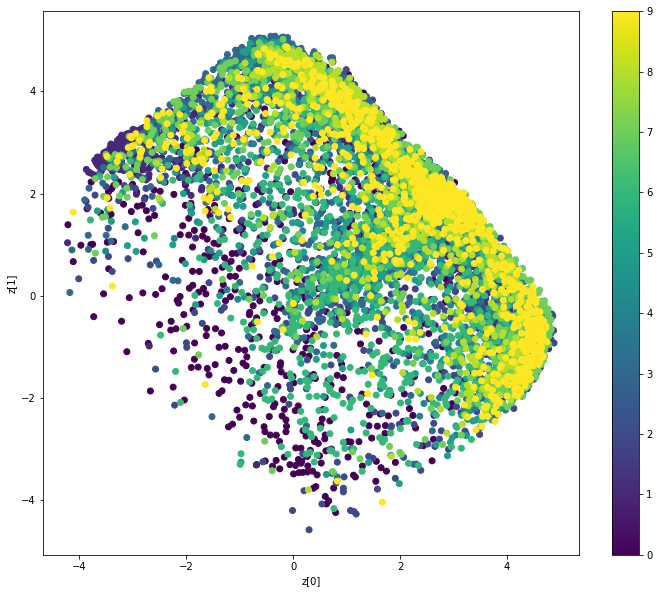

In [83]:
plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")

In [84]:
vae_test.set_weights(vae.get_weights())

In [86]:
from random import shuffle
shuffle(x_test)

In [87]:
score = vae_test.evaluate(x_test, x_test, verbose=1, batch_size=100)
#score = vae.evaluate(x_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 90us/step
Test loss: -0.022982282748562285
Test accuracy: 0.8686870735883713
